In [2]:
import json
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Read in data and map attributes to individuals

In [3]:
df_rel = pd.read_table("http://moreno.ss.uci.edu/lazega.dat",
                   skiprows=7) # Get relationship data
df_map = pd.read_table("http://moreno.ss.uci.edu/lazatt.dat")
df_cols = df_map[3:10] # dataframe with column labels
df_vals = df_map[11:] # dataframe with column mapping values
df_rel['DATA:'] = df_rel['DATA:'].apply(lambda x: x.split())
df_rel = df_rel['DATA:'].apply(pd.Series)
df_vals['DL'] = df_vals['DL'].apply(lambda x: x.split())
df_vals = df_vals['DL'].apply(pd.Series)
df_vals.columns = ['INDEX'] + df_cols['DL'].tolist() 

C:\Users\spiec\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [4]:
df_vals.head()

,INDEX,STATUS,GENDER,OFFICE,SENIORITY,AGE,PRACTICE,LAW_SCHOOL
11,01,1,1,1,31,64,1,1
12,02,1,1,1,32,62,2,1
13,03,1,1,2,13,67,1,1
14,04,1,1,1,31,59,2,3
15,05,1,1,2,31,59,1,2


### Build mapping dictionaries for gender and status

In [5]:
gender_dict = {int(k)-1:int(v) for k,v in zip(df_vals['INDEX'],df_vals['GENDER'])}
status_dict = {int(k)-1:int(v) for k,v in zip(df_vals['INDEX'],df_vals['STATUS'])}

In [6]:
#df_social


### Look at Social Network

#### Build social network graph

In [7]:
df_social = df_rel[71:142].astype(int).reset_index(drop=True)

G_social=nx.from_pandas_adjacency(df_social)
for node in list(G_social.nodes):
    G_social.nodes[node]['gender'] = gender_dict[node]
    G_social.nodes[node]['status'] = status_dict[node]

#### Get centrality

In [8]:
social_eig_centrality = nx.eigenvector_centrality(G_social, max_iter=1000)
social_deg_centrality = nx.degree_centrality(G_social)

for attribute in [1,2]:
    
    gender_centrality = {k:v for k,v in social_eig_centrality.items() if gender_dict[k]==attribute}
    status_centrality = {k:v for k,v in social_eig_centrality.items() if status_dict[k]==attribute}
    
    print('Gender : {}'.format(attribute))
    print(sorted([(round(x,3),round(y,3)) 
                  for x,y in gender_centrality.items()], 
                  key=lambda x: x[1], reverse=True)[:5])
    
    print('Status : {}'.format(attribute))
    print(sorted([(round(x,3),round(y,3)) 
                  for x,y in status_centrality.items()], 
                  key=lambda x: x[1], reverse=True)[:5])
    print('---------------------------------------------------------------')
    
print('Degree Centrality: All')
print(sorted([(round(x,3),round(y,3)) 
               for x,y in social_deg_centrality.items()], 
               key=lambda x: x[1], reverse=True)[:5])

Gender : 1
[(23, 0.265), (25, 0.25), (12, 0.245), (16, 0.236), (3, 0.216)]
Status : 1
[(23, 0.265), (25, 0.25), (12, 0.245), (16, 0.236), (26, 0.221)]
---------------------------------------------------------------
Gender : 2
[(26, 0.221), (42, 0.174), (37, 0.157), (28, 0.138), (38, 0.135)]
Status : 2
[(64, 0.196), (40, 0.177), (42, 0.174), (37, 0.157), (38, 0.135)]
---------------------------------------------------------------
Degree Centrality: All
[(30, 0.4), (16, 0.357), (23, 0.357), (12, 0.343), (25, 0.343)]


In terms of advice, the three influential partners are likely male, since they demonstrate the top status centrality as well as gender centrality. 

### Look at Advice Network

#### Build advice network graph

In [9]:
df_advice = df_rel[0:71].astype(int).reset_index(drop=True)

G_advice=nx.from_pandas_adjacency(df_advice)
for node in list(G_advice.nodes):
    G_advice.nodes[node]['gender'] = gender_dict[node]
    G_advice.nodes[node]['status'] = status_dict[node]

#### Get centrality

In [10]:
advice_eig_centrality = nx.eigenvector_centrality(G_advice, max_iter=1000)
advice_deg_centrality = nx.degree_centrality(G_advice)

for attribute in [1,2]:
    
    gender_centrality = {k:v for k,v in advice_eig_centrality.items() if gender_dict[k]==attribute}
    status_centrality = {k:v for k,v in advice_eig_centrality.items() if status_dict[k]==attribute}
    
    print('Gender : {}'.format(attribute))
    print(sorted([(round(x,3),round(y,3)) 
                  for x,y in gender_centrality.items()], 
                  key=lambda x: x[1], reverse=True)[:5])
    
    print('Status : {}'.format(attribute))
    print(sorted([(round(x,3),round(y,3)) 
                  for x,y in status_centrality.items()], 
                  key=lambda x: x[1], reverse=True)[:5])
    print('---------------------------------------------------------------')
    
print('Degree Centrality: All')
print(sorted([(round(x,3),round(y,3)) 
               for x,y in advice_deg_centrality.items()], 
               key=lambda x: x[1], reverse=True)[:5])

Gender : 1
[(25, 0.251), (12, 0.221), (23, 0.206), (40, 0.179), (15, 0.169)]
Status : 1
[(25, 0.251), (12, 0.221), (23, 0.206), (15, 0.169), (16, 0.166)]
---------------------------------------------------------------
Gender : 2
[(26, 0.159), (33, 0.132), (38, 0.127), (28, 0.121), (37, 0.117)]
Status : 2
[(40, 0.179), (41, 0.154), (54, 0.152), (64, 0.151), (39, 0.15)]
---------------------------------------------------------------
Degree Centrality: All
[(25, 0.657), (12, 0.571), (23, 0.514), (15, 0.486), (40, 0.457)]


### Look at Co-worker Network

#### Build co-worker network graph

In [11]:
df_work = df_rel[142:].astype(int).reset_index(drop=True)

G_work=nx.from_pandas_adjacency(df_work)
for node in list(G_work.nodes):
    G_work.nodes[node]['gender'] = gender_dict[node]
    G_work.nodes[node]['status'] = status_dict[node]

In [12]:
work_eig_centrality = nx.eigenvector_centrality(G_work, max_iter=1000)
work_deg_centrality = nx.degree_centrality(G_work)

for attribute in [1,2]:
    
    gender_centrality = {k:v for k,v in work_eig_centrality.items() if gender_dict[k]==attribute}
    status_centrality = {k:v for k,v in work_eig_centrality.items() if status_dict[k]==attribute}
    
    print('Gender : {}'.format(attribute))
    print(sorted([(round(x,3),round(y,3)) 
                  for x,y in gender_centrality.items()], 
                  key=lambda x: x[1], reverse=True)[:5])
    
    print('Status : {}'.format(attribute))
    print(sorted([(round(x,3),round(y,3)) 
                  for x,y in status_centrality.items()], 
                  key=lambda x: x[1], reverse=True)[:5])
    print('---------------------------------------------------------------')
    
print('Degree Centrality: All')
print(sorted([(round(x,3),round(y,3)) 
               for x,y in work_deg_centrality.items()], 
               key=lambda x: x[1], reverse=True)[:5])

Gender : 1
[(23, 0.236), (25, 0.235), (21, 0.197), (14, 0.195), (18, 0.195)]
Status : 1
[(23, 0.236), (25, 0.235), (21, 0.197), (14, 0.195), (18, 0.195)]
---------------------------------------------------------------
Gender : 2
[(28, 0.146), (42, 0.145), (33, 0.14), (37, 0.134), (38, 0.116)]
Status : 2
[(65, 0.154), (64, 0.148), (42, 0.145), (67, 0.135), (37, 0.134)]
---------------------------------------------------------------
Degree Centrality: All
[(23, 0.643), (25, 0.614), (14, 0.529), (18, 0.529), (21, 0.514)]


In [13]:
nx.write_gml(G_work, 'G_work.gml')
nx.write_gml(G_social, 'G_social.gml')
nx.write_gml(G_advice, 'G_advice.gml')

### Social Network - by Gender

Orange is male, purple is female. Size indicates degree.

![title](graphics/social_gender.png)

### Social Network - Status

Brown is partner, green is associate. Size indicates degree

![title](graphics/social_status.png)

### Advice Network - by Gender

Orange is male, purple is female. Size indicates degree

![title](graphics/advice_gender.png)

### Advice Network - by Status

Brown is partner, green is associate. Size indicates degree

![title](graphics/advice_status.png)

### Work Network - by Gender

Orange is male, purple is female. Size indicates degree

![title](graphics/work_gender.png)

### Work Network - by Status

Brown is partner, green is associate. Size indicates degree

![title](graphics/work_status.png)

#### Create dataframes 

In [14]:
from pandas import DataFrame
df_work_eigen = DataFrame(list(work_eig_centrality.items()),columns = ['index','eigen_centrality']) 
df_work_eigen['gender'] = df_work_eigen['index'].map(gender_dict)

work_male_eigen = {k:v for k,v in work_eig_centrality.items() if gender_dict[k]==1}
work_df_male = DataFrame(list(work_male_eigen.items()), columns = ['index','eigen_centrality']) 
work_female_eigen = {k:v for k,v in work_eig_centrality.items() if gender_dict[k]==2}
work_df_female = DataFrame(list(work_female_eigen.items()), columns = ['index','eigen_centrality']) 

#### Scatter Plot of Co-Worker Network Eigenvector Centrality by Gender 

Text(0.42500000000000426, 0.5, 'Eigenvector Centrality')

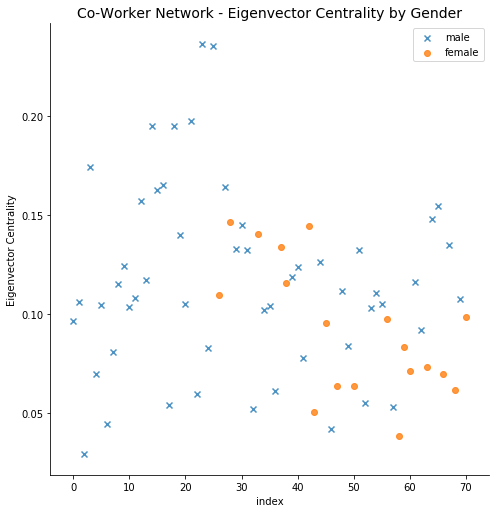

In [31]:
sns.lmplot( x="index", y="eigen_centrality", data=df_work_eigen, fit_reg=False, hue='gender', markers=["x", "o"], 
           height = 7, legend = False)
plt.legend(labels={'male', 'female'})
plt.title('Co-Worker Network - Eigenvector Centrality by Gender', fontsize = 14) 
plt.ylabel('Eigenvector Centrality')

#### Get Mean and Variance for Co-Worker Network Eigenvector Centrality by Gender

In [37]:
print('Co-Worker Network Eigenvector Centrality Statistics')
print('Male mean: {}'.format(round(np.mean(work_df_male['eigen_centrality']),3)))
print('Female mean: {}'.format(round(np.mean(work_df_female['eigen_centrality']),3)))
print('Male variance: {}'.format(round(np.var(work_df_male['eigen_centrality']),4)))
print('Female variance: {}'.format(round(np.var(work_df_female['eigen_centrality']),4)))


Co-Worker Network Eigenvector Centrality Statistics
Male mean: 0.116
Female mean: 0.092
Male variance: 0.0021
Female variance: 0.0011


### T-Test for Differences in Co-Worker Eigenvector Centrality - Gender  

There is a statistically significant difference between mean co-worker eigenvector centralities for males and females (p-value = 0.02). 

In [72]:
from scipy import stats
stats.ttest_ind(work_df_male['eigen_centrality'],work_df_female['eigen_centrality'], equal_var = False)

Ttest_indResult(statistic=2.3472391765788325, pvalue=0.023820747795196332)